## This notebook does all the D Separation and Conditional Independence tests on the DAG and data respectively using the R package - [bnlearn](https://www.bnlearn.com/)

Required Packages to run this Notebook:

- [bnlearn](https://www.bnlearn.com/)
- [Rgraphviz](https://www.bioconductor.org/packages/release/bioc/html/Rgraphviz.html)

<strong>Note:</strong> 

This notebook runs on a Python Kernel, so as to allow a smooth transition between code in R and Python. 

To run R code in any cell, we use [R Magic](https://rpy2.github.io/doc/latest/html/interactive.html) by putting '%%R' on the first line of the respective cells.


In [38]:
# Ignores all warnings

import warnings
warnings.filterwarnings('ignore')

<strong>Windows Users:</strong> 

R Magic sends the output of the respective cells on the Jupyter console in Windows. Use the [RWinOut](https://github.com/vitorcurtis/RWinOut) extension to fetch R Magic output from the Jupyter console. 

_(RWinOut also has rpy2.ipython that's a prerequisite for R Magic in Python Notebooks)_


In [39]:
#Loads the extention RWinOut
%load_ext RWinOut

The RWinOut extension is already loaded. To reload it, use:
  %reload_ext RWinOut


In [40]:
%%R

# Loads the package bnlearn
library(bnlearn)

## Step 1: Create the DAG. 

Bnlearn lets you create a dag from a string of nodes using the function [model2network](https://www.bnlearn.com/documentation/man/modelstring.html)

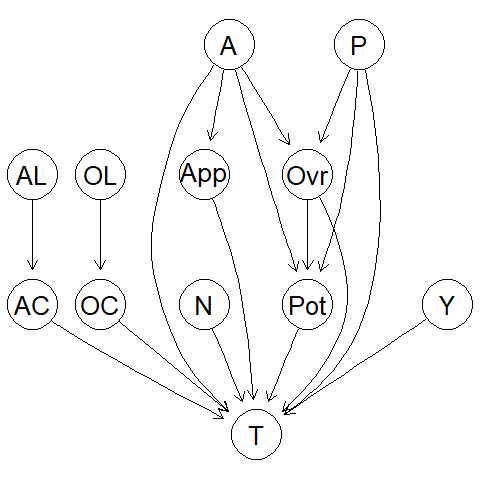

In [41]:
%%R

#create a DAG by providing a modelstring as an argument to model2network
dag <- model2network("[A][App|A][N][P][Ovr|P:A][Pot|P:A:Ovr][OC|OL][AC|AL][OL][AL][Y][T|A:App:N:P:Ovr:Pot:OC:AC:Y]")

#plot the dag using graphviz.plot from the package Rgraphviz
graphviz.plot(dag)

## Step 2: Read the data

Read the data into a table and making sure all the column names are the same as the nodes in the DAG

In [42]:
%%R

# read the data from a csv file
transfers_11 <- read.table("../data/modelling datasets/transfers_11.csv", sep=',', header = TRUE)
head(transfers_11)

              AL          Y               OL P     AC     OC   A       T
1 Premier League Before2016          Ligue 1 D Tier_2 Tier_1 U25 10Mto5M
2   1 Bundesliga Before2016          Ligue 1 M Tier_1 Tier_1 U30 10Mto5M
3        Serie A Before2016          Serie A F Tier_2 Tier_3 U21 10Mto5M
4        Serie A Before2016          Serie A F Tier_2 Tier_1 U25 10Mto5M
5        Serie A Before2016          Serie A M Tier_2 Tier_2 U21 10Mto5M
6          Other Before2016 Primera Division F Tier_1 Tier_3 U25 10Mto5M
      Pot    Ovr      App  N
1 85above 75to84 150to300 EU
2  75to84 75to84 150to300 AF
3  75to84 65to74  50to150 AF
4  75to84 65to74  50to150 AF
5  75to84 65to74  50to150 AF
6  75to84 65to74  50to150 AF


## Step 3: D Separation Tests and global Markov property assumption

### 3.1

A typical D separation test checks whether a Node x is d-separated from another Node y, given the set of Nodes z.
<br>
So, you need these three arguments, in a typical argument set.

Create a function that takes all the nodes in your DAG and creates argument sets for all the D separation tests.

In [43]:
%%R

# This is the same as the bnlearn's `dsep` function but avoids some type checking which would throw errors
d_sep <- bnlearn:::dseparation

# set of nodes in the DAG
vars <- nodes(dag)

# makes every possible pair out of the nodes in the DAG
pairs <- combn(x = vars, 2, list)
arg_sets <- list()

# iterates through the pairs and creates conditioning set Z for all possible D Separation tests for that pair
for(pair in pairs){
    others <- setdiff(vars, pair)
    conditioning_sets <- unlist(lapply(0:4, function(.x) combn(others, .x, list)), recursive = F)
    for(set in conditioning_sets){
        args <- list(x = pair[1], y = pair[2], z = set)
        arg_sets <- c(arg_sets, list(args))
    }
}
                                       

The above code did a bit of combinatorics that calculates all the pairs to compare, i.e. the ‘x’ and ‘y’ arguments
in d_sep. For each pair, all subsets of size 0 - 4 variables that are not in that pair are calculated. Each pair /
other variable subset combination is an element in the arg_sets list.

### 3.2

Iterate through all the argument sets and pass them as arguments, along with the DAG, to the d_sep function. 

All the tests that output TRUE as the result, are the True D Separation statements in the DAG.

Add all of them in a list

In [44]:
%%R

true_dsep_list <- list()

# iterate through argument sets to find all true d-separation statements
for(arg_set in arg_sets){
    if(d_sep(bn=dag, x=arg_set$x, y=arg_set$y, z=arg_set$z)){
        true_dsep_list <- c(true_dsep_list, list(arg_set))
    }
}


### 3.3 Conditional independence tests on true d-separation statements

The global Markov property assumption states that every true d-separation statement in the DAG corresponds to a true conditional independence statement in the joint probability distribution.

We evaluate the global Markov property assumption by doing a conditional independence test for each true d-separation statemen and print any test results where the p-value is not greater than .05.


In [45]:
%%R
alpha <- .05
false_ci_tests <- list()
for(true_dsep_statement in true_dsep_list){
    ci_test_outcome <- ci.test(x=true_dsep_statement$x, y=true_dsep_statement$y, z=true_dsep_statement$z, data = transfers_11)
    ci_test_pvalue <- ci_test_outcome$p.value
    if (ci_test_pvalue <= alpha){
        false_ci_tests <- c(false_ci_tests, list(ci_test_outcome))
    }
}
false_ci_tests

[[1]]

	Mutual Information (disc.)

data:  A ~ AC | Y
mi = 35.525, df = 18, p-value = 0.008112
alternative hypothesis: true value is greater than 0


[[2]]

	Mutual Information (disc.)

data:  A ~ AL  
mi = 45.28, df = 15, p-value = 6.916e-05
alternative hypothesis: true value is greater than 0


[[3]]

	Mutual Information (disc.)

data:  A ~ AL | App
mi = 100.02, df = 60, p-value = 0.000912
alternative hypothesis: true value is greater than 0


[[4]]

	Mutual Information (disc.)

data:  A ~ AL | OC
mi = 92.56, df = 60, p-value = 0.004426
alternative hypothesis: true value is greater than 0


[[5]]

	Mutual Information (disc.)

data:  A ~ AL | OL
mi = 168.18, df = 90, p-value = 1.135e-06
alternative hypothesis: true value is greater than 0


[[6]]

	Mutual Information (disc.)

data:  A ~ AL | P
mi = 79.222, df = 60, p-value = 0.04891
alternative hypothesis: true value is greater than 0


[[7]]

	Mutual Information (disc.)

data:  A ~ AL | Pot
mi = 92.241, df = 60, p-value = 0.004719
al

mi = 37.675, df = 18, p-value = 0.004275
alternative hypothesis: true value is greater than 0


[[115]]

	Mutual Information (disc.)

data:  AC ~ Pot  
mi = 71.86, df = 9, p-value = 6.568e-12
alternative hypothesis: true value is greater than 0


[[116]]

	Mutual Information (disc.)

data:  AC ~ Pot | A
mi = 91.401, df = 36, p-value = 1.033e-06
alternative hypothesis: true value is greater than 0


[[117]]

	Mutual Information (disc.)

data:  AC ~ Pot | AL
mi = 98.574, df = 54, p-value = 0.0002034
alternative hypothesis: true value is greater than 0


[[118]]

	Mutual Information (disc.)

data:  AC ~ Pot | App
mi = 99.415, df = 36, p-value = 7.514e-08
alternative hypothesis: true value is greater than 0


[[119]]

	Mutual Information (disc.)

data:  AC ~ Pot | N
mi = 75.536, df = 54, p-value = 0.02809
alternative hypothesis: true value is greater than 0


[[120]]

	Mutual Information (disc.)

data:  AC ~ Pot | OC
mi = 68.314, df = 36, p-value = 0.0009172
alternative hypothesis: true va

mi = 1219.1, df = 600, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0


[[226]]

	Mutual Information (disc.)

data:  AL ~ OL | App + OC
mi = 1326.2, df = 400, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0


[[227]]

	Mutual Information (disc.)

data:  AL ~ OL | App + Ovr
mi = 1189.4, df = 400, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0


[[228]]

	Mutual Information (disc.)

data:  AL ~ OL | App + P
mi = 1230.7, df = 400, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0


[[229]]

	Mutual Information (disc.)

data:  AL ~ OL | App + Pot
mi = 1123.4, df = 400, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0


[[230]]

	Mutual Information (disc.)

data:  AL ~ OL | App + Y
mi = 1124, df = 200, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0


[[231]]

	Mutual Information (disc.)

data:  AL ~ OL | N + OC
mi = 1264, df = 600, p-value < 2.2e-16
alter

alternative hypothesis: true value is greater than 0


[[337]]

	Mutual Information (disc.)

data:  App ~ OL | N
mi = 176.66, df = 90, p-value = 1.36e-07
alternative hypothesis: true value is greater than 0


[[338]]

	Mutual Information (disc.)

data:  App ~ OL | OC
mi = 120.8, df = 60, p-value = 5.564e-06
alternative hypothesis: true value is greater than 0


[[339]]

	Mutual Information (disc.)

data:  App ~ OL | Ovr
mi = 125.44, df = 60, p-value = 1.579e-06
alternative hypothesis: true value is greater than 0


[[340]]

	Mutual Information (disc.)

data:  App ~ OL | P
mi = 159.04, df = 60, p-value = 6.669e-11
alternative hypothesis: true value is greater than 0


[[341]]

	Mutual Information (disc.)

data:  App ~ OL | Pot
mi = 138.45, df = 60, p-value = 3.851e-08
alternative hypothesis: true value is greater than 0


[[342]]

	Mutual Information (disc.)

data:  App ~ OL | Y
mi = 112.2, df = 30, p-value = 2.007e-11
alternative hypothesis: true value is greater than 0


[[343]]

	Mut

alternative hypothesis: true value is greater than 0


[[448]]

	Mutual Information (disc.)

data:  OC ~ Ovr | App + P
mi = 340.94, df = 144, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0


[[449]]

	Mutual Information (disc.)

data:  OC ~ Ovr | App + Pot
mi = 189.5, df = 144, p-value = 0.006575
alternative hypothesis: true value is greater than 0


[[450]]

	Mutual Information (disc.)

data:  OC ~ Ovr | App + Y
mi = 294.37, df = 72, p-value < 2.2e-16
alternative hypothesis: true value is greater than 0


[[451]]

	Mutual Information (disc.)

data:  OC ~ Ovr | N + P
mi = 428.84, df = 216, p-value = 3.405e-16
alternative hypothesis: true value is greater than 0


[[452]]

	Mutual Information (disc.)

data:  OC ~ Ovr | N + Pot
mi = 269.49, df = 216, p-value = 0.007787
alternative hypothesis: true value is greater than 0


[[453]]

	Mutual Information (disc.)

data:  OC ~ Ovr | N + Y
mi = 372.88, df = 108, p-value < 2.2e-16
alternative hypothesis: true value is gr

In [46]:
%%R
# count of true d-sep statements
count_true_dsep_statements <- length(true_dsep_list)

# count of false ci tests
count_false_ci_tests_from_true_dsep_list <- length(false_ci_tests)

# count of true dsep statements that are also true ci statements
count_true_dsep_true_ci_statements <- count_true_dsep_statements - count_false_ci_tests_from_true_dsep_list

# % of true dsep statements that are also true ci statements
answer <- count_true_dsep_true_ci_statements/count_true_dsep_statements*100
answer

[1] 95.53434


## Step 4: Conditional Independence tests

### 4.1

Now, we iterate through the arg_sets list again, run the conditional independence test for each argument set, creating new lists of sets where we conclude the conditional independence statement is true and false respectively.

In [47]:
%%R
alpha <- .05
total_true_ci_tests <- list()
total_false_ci_tests <- list()
for(arg_set in arg_sets){
    ci_test_outcome <- ci.test(x=arg_set$x, y=arg_set$y, z=arg_set$z, data = transfers_11)
    ci_test_pvalue <- ci_test_outcome$p.value
    if (ci_test_pvalue > alpha){
        total_true_ci_tests <- c(total_true_ci_tests, list(ci_test_outcome))
    }
    else{
        total_false_ci_tests <- c(total_false_ci_tests, list(ci_test_outcome))
    }
}

### 4.2 Faithfulness Assumption

The Faithfulness Assumption states that every true conditional independence statement about the joint distribution corresponds
to a true d-separation statement in the DAG

We evaluate the Faithfulness Assumption by calculating the percentage of true conditional inpdendence statements that are also true d-separation statements

In [48]:
%%R

# count of total true ci statements
count_total_true_ci_statements <- length(total_true_ci_tests)

# percentage of true conditional inpdendence statements that are also true d-separation statements
answer2 <- count_true_dsep_true_ci_statements/count_total_true_ci_statements*100
answer2

[1] 48.99187


### Incorporating unobserved confounders to reduce True D Sep statements

From the unobserved confounders that we found in Causal Fusion, lets try to see if we can get rid of those D Separation statements that they invalidate and then see the performance of the model on the 2 metrics we defined earlier, i.e. The Global Markov Property and the Faithfulness Assumption

In [49]:
%%R

length(arg_sets)

[1] 25476


### Removing the arg sets that correspond with unobserved confounders

In [50]:
%%R

reduced_set <- list()
for(arg_set in arg_sets){
    
    if((arg_set$x == "A" && arg_set$y == "AC") || (arg_set$x == "AC" && arg_set$y == "A")){
        # removing A and AC due to unobserved confounders
        
    } else if((arg_set$x == "P" && arg_set$y == "AC") || (arg_set$x == "AC" && arg_set$y == "P")){
        # removing Y and AC due to unobserved confounders
        
    } else if((arg_set$x == "Y" && arg_set$y == "AC") || (arg_set$x == "AC" && arg_set$y == "Y")){
        # removing P and AC due to unobserved confounders
        
    } else{
        reduced_set <- c(reduced_set, list(arg_set))
        
    }
}
length(reduced_set)

[1] 24318


### Creating new True D Separation Statements list

In [51]:
%%R

new_true_dsep_list <- list()
# iterate through argument sets to find all true d-separation statements
for(arg_set in reduced_set){
    if(d_sep(bn=dag, x=arg_set$x, y=arg_set$y, z=arg_set$z)){
        new_true_dsep_list <- c(new_true_dsep_list, list(arg_set))
    }
}
length(new_true_dsep_list)

[1] 11593


### Evaluating the Global Markov Property Assumption and the Faithfulness Assumption

In [52]:
%%R
new_false_ci_tests <- list()
for(true_dsep_statement in new_true_dsep_list){
    ci_test_outcome <- ci.test(x=true_dsep_statement$x, y=true_dsep_statement$y, z=true_dsep_statement$z, data = transfers_11)
    ci_test_pvalue <- ci_test_outcome$p.value
    if (ci_test_pvalue <= alpha){
        new_false_ci_tests <- c(new_false_ci_tests, list(ci_test_outcome))
    }
}


In [53]:
%%R
# count of true d-sep statements
new_count_true_dsep_statements <- length(new_true_dsep_list)
# count of false ci tests
new_count_false_ci_tests_from_true_dsep_list <- length(new_false_ci_tests)
# count of true dsep statements that are also true ci statements
new_count_true_dsep_true_ci_statements <- new_count_true_dsep_statements - new_count_false_ci_tests_from_true_dsep_list
# % of true dsep statements that are also true ci statements
new_answer <- new_count_true_dsep_true_ci_statements/new_count_true_dsep_statements*100
new_answer

[1] 95.47141


In [54]:
%%R
new_total_true_ci_tests <- list()
new_total_false_ci_tests <- list()
for(arg_set in reduced_set){
    ci_test_outcome <- ci.test(x=arg_set$x, y=arg_set$y, z=arg_set$z, data = transfers_11)
    ci_test_pvalue <- ci_test_outcome$p.value
    if (ci_test_pvalue > alpha){
        new_total_true_ci_tests <- c(new_total_true_ci_tests, list(ci_test_outcome))
    }
    else{
        new_total_false_ci_tests <- c(new_total_false_ci_tests, list(ci_test_outcome))
    }
}

In [55]:
%%R

# count of total true ci statements
new_count_total_true_ci_statements <- length(new_total_true_ci_tests)

# percentage of true conditional inpdendence statements that are also true d-separation statements
new_answer2 <- new_count_true_dsep_true_ci_statements/new_count_total_true_ci_statements*100
new_answer2

[1] 48.16152


### This shows that removing the unobserved confounders had more or less no effect on our evaluation for the Global Markov Property and the Faithfulness Assumption